# Accuracy/F1 of Our Models on Our Survey Answers

### Choose Models to Test

Possible arguments for the Model:
- head_type
    - 'Classification'
    - 'Regression'
    - 'MixedCNN'
    - 'CNN' (if you changed architecture make sure it matches the one in custom heads)
- model
    - 'DistilBERT' - default
    - 'MpNet'
    - 'RoBERTa'
    - 'RoBERTaLarge'
    - 'DeBerta'
- train
    - 'Full' - default
    - 'LoRA'
    - 'Baseline'

In [1]:
import os
os.chdir("../..")

In [2]:
from App.ModelWrapper.model_wrapper import Model

models = [
    Model(head_type='CNN'),
    Model(head_type='Classification', model="RoBERTa")
]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(DistilBERT CNN Full) loading model from Training/MODELS/DistilBERTCNNFull/model
(CNN) loading state dict
Initialized model (CNN)
(RoBERTa Classification Full) loading model from Training/MODELS/RoBERTaClassificationFull/model
Initialized model (RoBERTa Classification Full)


### Testing Accuracy for Each Trait

(CNN): 100%|██████████| 36/36 [00:00<00:00, 40.77it/s]


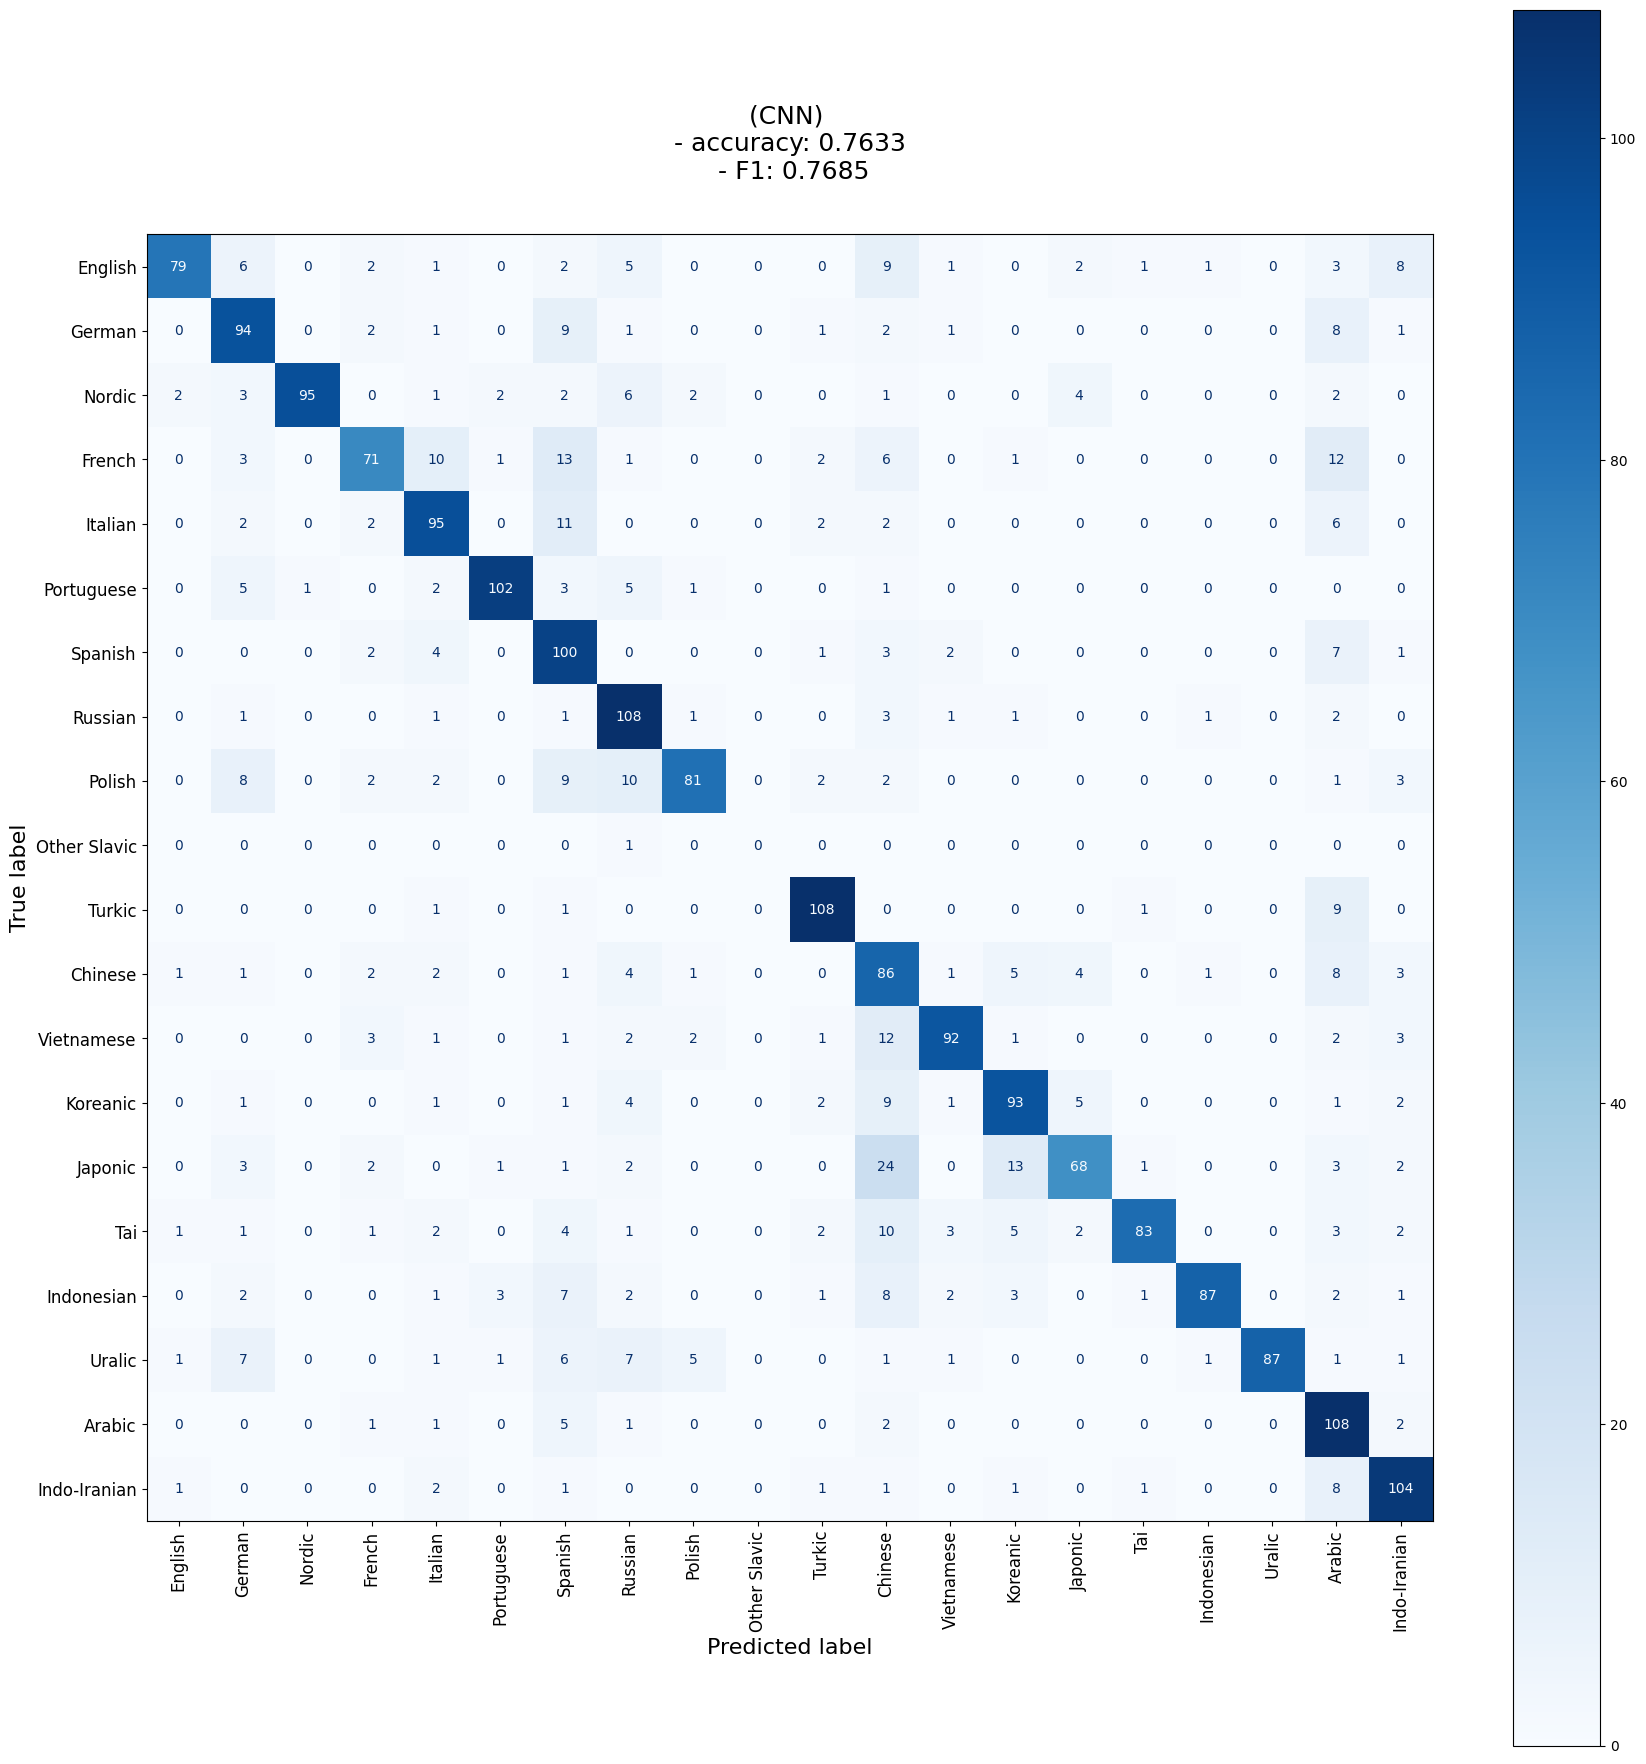


[(CNN)]: 
 - accuracy: 0.7633 
 - F1: 0.7685



(RoBERTa Classification Full): 100%|██████████| 36/36 [00:12<00:00,  2.81it/s]


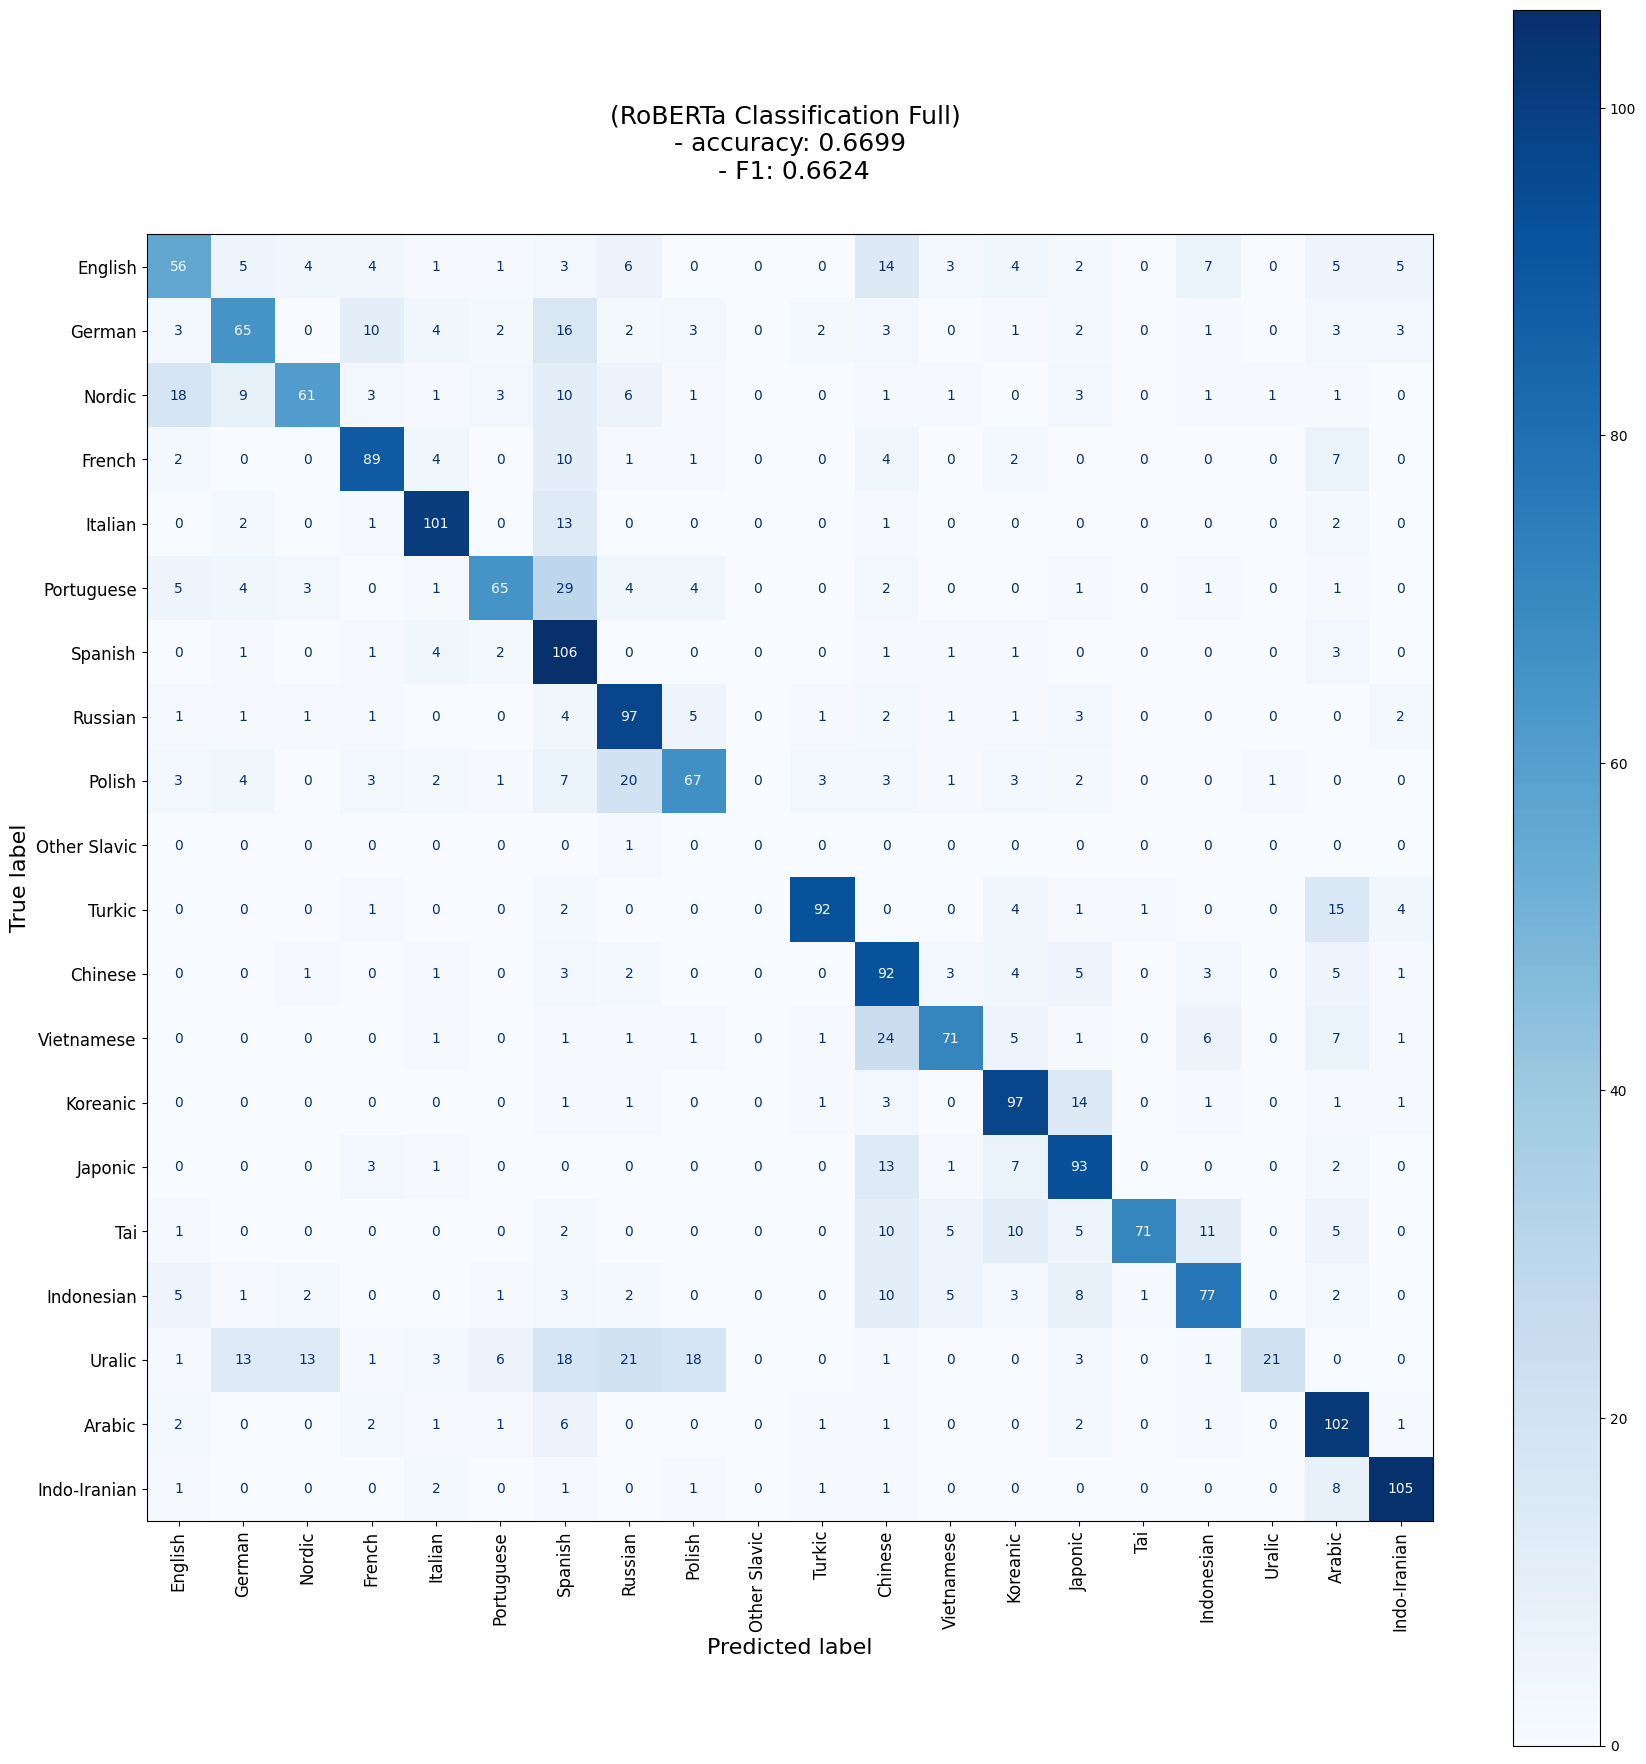


[(RoBERTa Classification Full)]: 
 - accuracy: 0.6699 
 - F1: 0.6624



In [ ]:
from evaluate import load
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = load("accuracy")
f1_metric = load("f1")

batch_size = 64

for model in models:
    # df = pd.read_csv("Training/DATA/NEW/notCombined/test.csv")
    # df = pd.read_parquet("Training/DATA/NEW/notCombined/test_no_slavic.parquet") # doesnt work cause there is no other slavic (and label amount messes up)
    df = pd.read_parquet("Training/DATA/OLD/validate_no_other_slavic.parquet")
    # df = pd.read_parquet("Training/DATA/OLD/validate.parquet")

    invert_labels = {v: k for k, v in model.label_map.items()} if model.label_map != None else lambda x: x

    all_preds = []
    all_refs = df["language"].map(invert_labels).to_numpy()

    for start in tqdm(range(0, len(df), batch_size), desc=model.name):
        batch = df['text'].iloc[start:start + batch_size].tolist()
        outputs = model.predict(batch)
        outputs = np.argmax(outputs, axis=1)
        all_preds.extend(outputs)

    acc = accuracy.compute(predictions=all_preds, references=all_refs)
    f1 = f1_metric.compute(predictions=all_preds, references=all_refs, average="weighted")

    cm = confusion_matrix(all_refs, all_preds)

    fig, ax = plt.subplots(figsize=(18, 18))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=invert_labels
    )
    disp.plot(
        ax=ax,
        cmap="Blues",
        xticks_rotation=90,
        values_format="d",
        colorbar=True
    )
    ax.set_title(f"{model.name} \n - accuracy: {acc["accuracy"]:.4f} \n - F1: {f1["f1"]:.4f}\n ", fontsize=18, pad=20)
    ax.set_xlabel("Predicted label", fontsize=16)
    ax.set_ylabel("True label", fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=12)

    plt.tight_layout(pad=2.0)
    plt.savefig(f"{model.name}_cm.png")
    plt.show()

    print(f"\n[{model.name}]: \n - accuracy: {acc["accuracy"]:.4f} \n - F1: {f1["f1"]:.4f}\n")
